# Семинар 2. RAG (Retrieval Augmented Generation). Часть 1

С использованием

https://github.com/huggingface/cookbook/blob/main/notebooks/en/rag_zephyr_langchain.ipynb.   
https://github.com/huggingface/cookbook/blob/main/notebooks/en/rag_evaluation.ipynb.   
https://github.com/a-milenkin/LLM_practical_course/blob/main/notebooks/M4_RAG.ipynb.  
https://www.appliedai.de/assets/files/LLM-Whitepaper-final_Digital03.pdf


## Чуть ландшафта

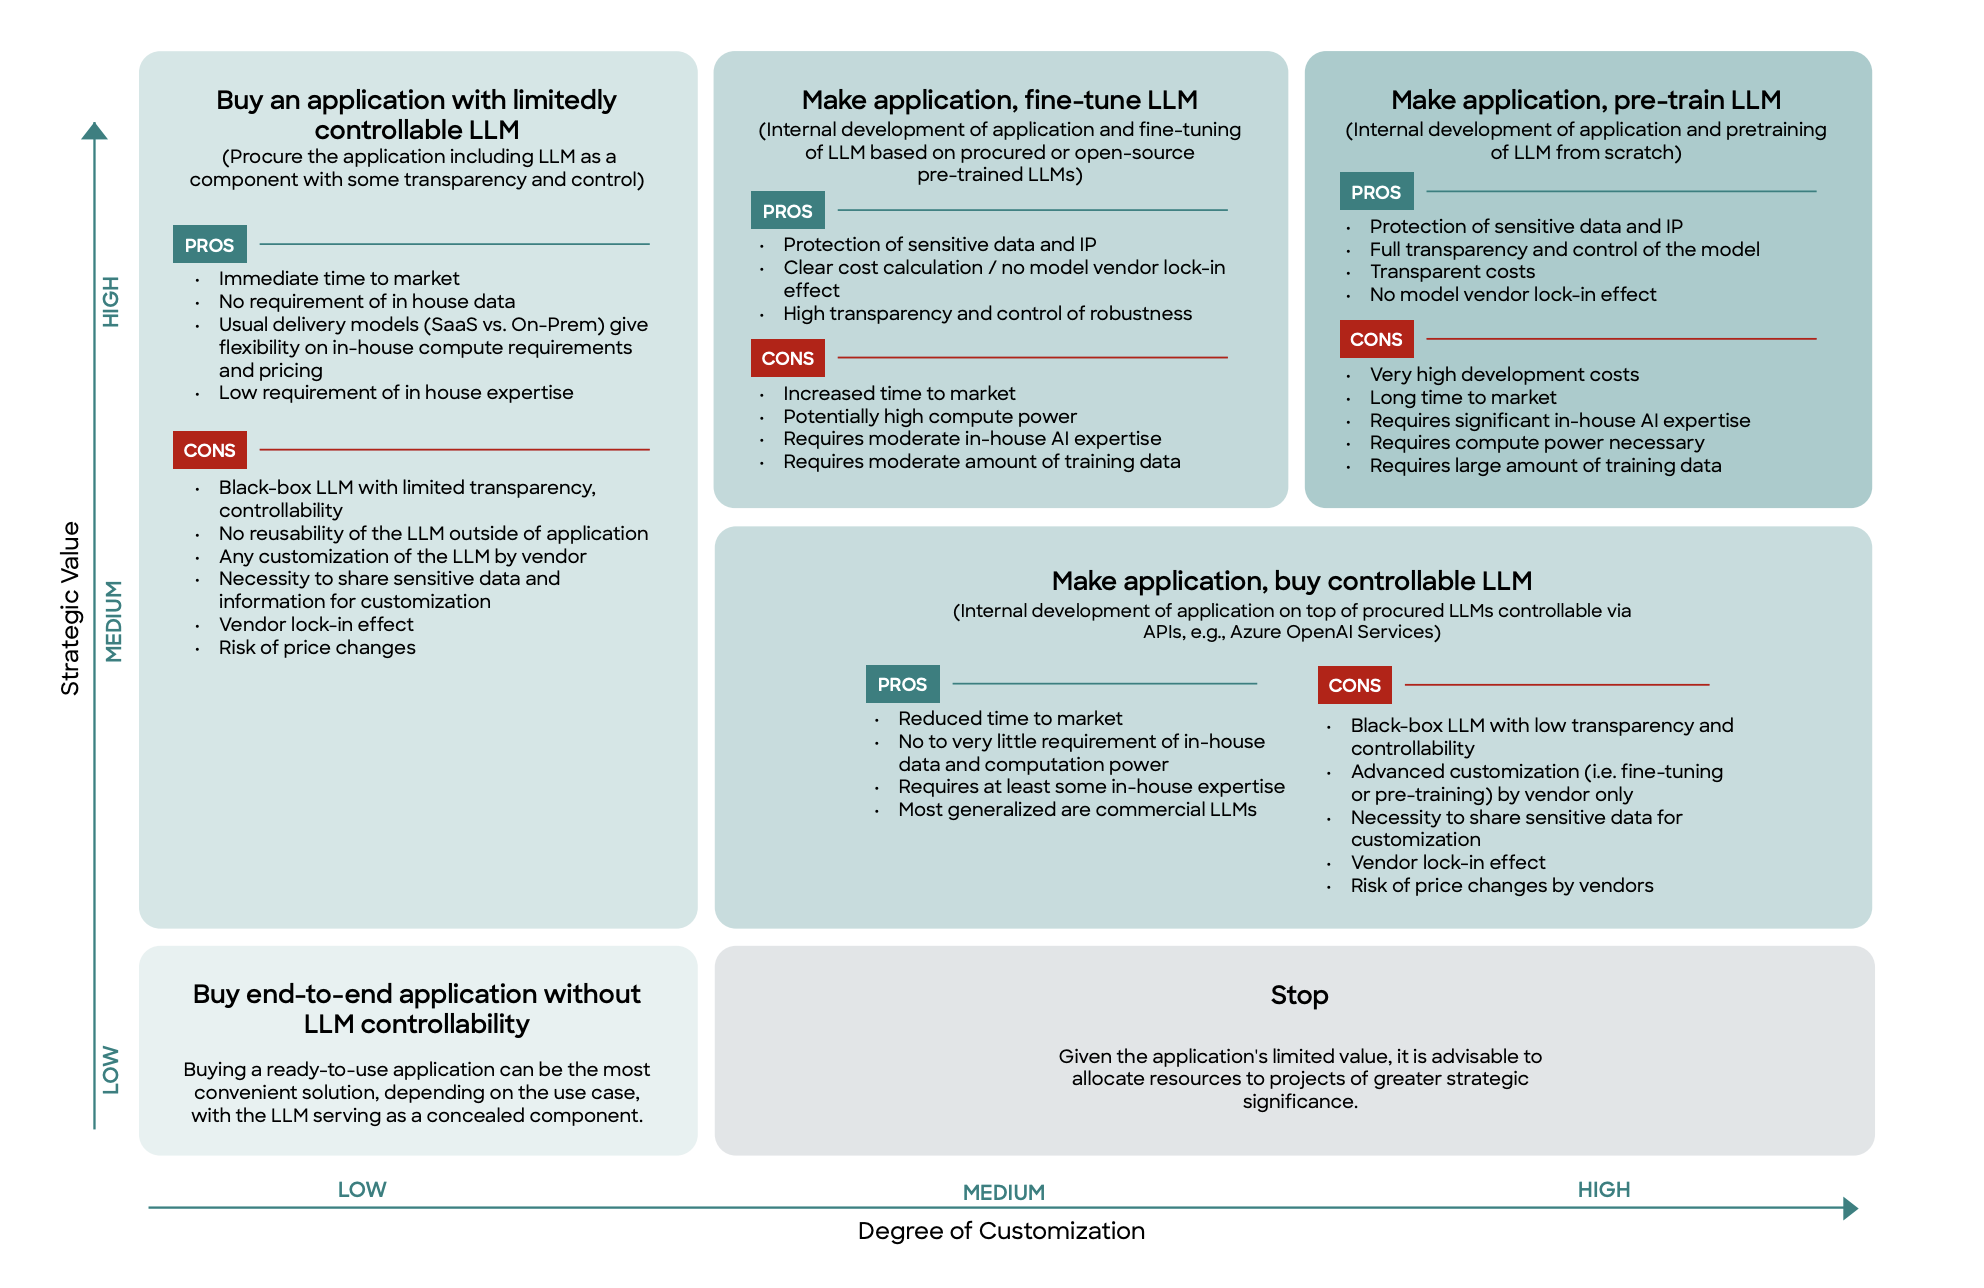

## RAG. Картинка попроще




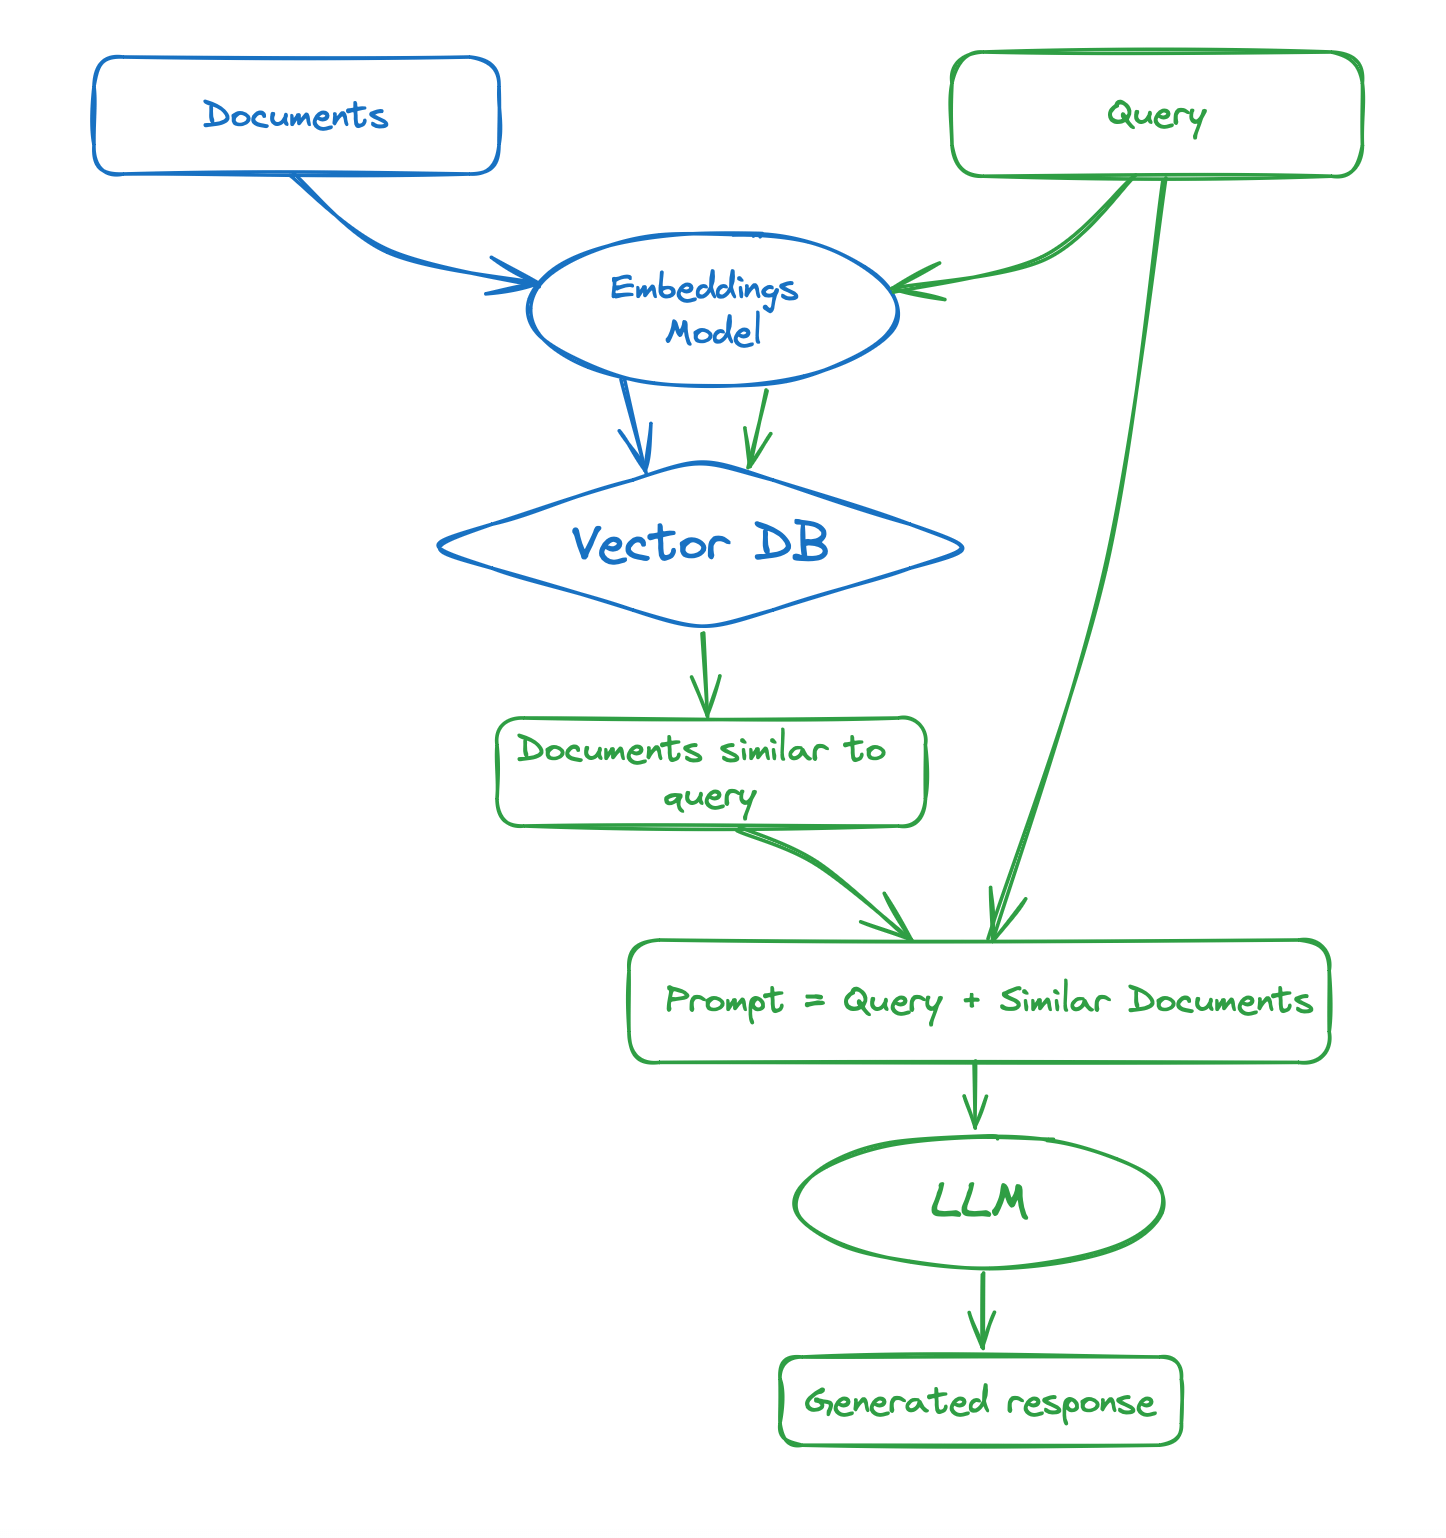

# Как получить токен HuggingFace?



1.   Зарегистрироваться на HuggingFace
2.   Перейти на страницу с токенами https://huggingface.co/settings/tokens
3.   Придумать название и нажать New Token
4.   Скопировать токен



# Как получить токен OPEN_AI?

https://platform.openai.com/settings/organization/api-keys

In [ ]:
!pip install -q --upgrade langchain langchain-core langchain-community

In [ ]:
!pip install -q "giskard[llm]" unstructured

In [ ]:
!pip install sentence_transformers faiss-cpu pypdf -q

In [ ]:
!pip install rank_bm25 -q

In [ ]:
import os
os.environ['HUGGINGFACEHUB_API_TOKEN'] = ''#YOUR_TOKEN'

In [ ]:
from giskard.rag import generate_testset, KnowledgeBase
from langchain_community.document_loaders import UnstructuredMarkdownLoader
import os
import tqdm
import pandas as pd

In [ ]:
from langchain_community.llms import HuggingFaceEndpoint
llm = HuggingFaceEndpoint(repo_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation")

/var/folders/cl/pkfxcjg93z36trc318pw0_z5kft9vn/T/ipykernel_13916/3191198268.py:2: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  llm = HuggingFaceEndpoint(repo_id="HuggingFaceH4/zephyr-7b-beta",


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /Users/nrzelinsky/.cache/huggingface/token
Login successful


In [ ]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("https://ussr2.ru/_ld/0/79_Uells_G-Rossia_.pdf")
documents = loader.load_and_split()
len(documents)

221

# Разбиение на чанки

In [ ]:
from langchain.text_splitter import CharacterTextSplitter
splitter = CharacterTextSplitter(
    separator='\n',
    chunk_size=1000,
    chunk_overlap=150,
    length_function=len,
    is_separator_regex=False)
documents = loader.load_and_split(splitter)
len(documents)

450

Нарезка на чанки -- часть, на которой RAG часто теряет значительную долю качества, в апреле вышла Chonkie https://github.com/chonkie-inc/chonkie
для того чтобы дать максимум гибкости в нарезке на чанки, скрин из из репо

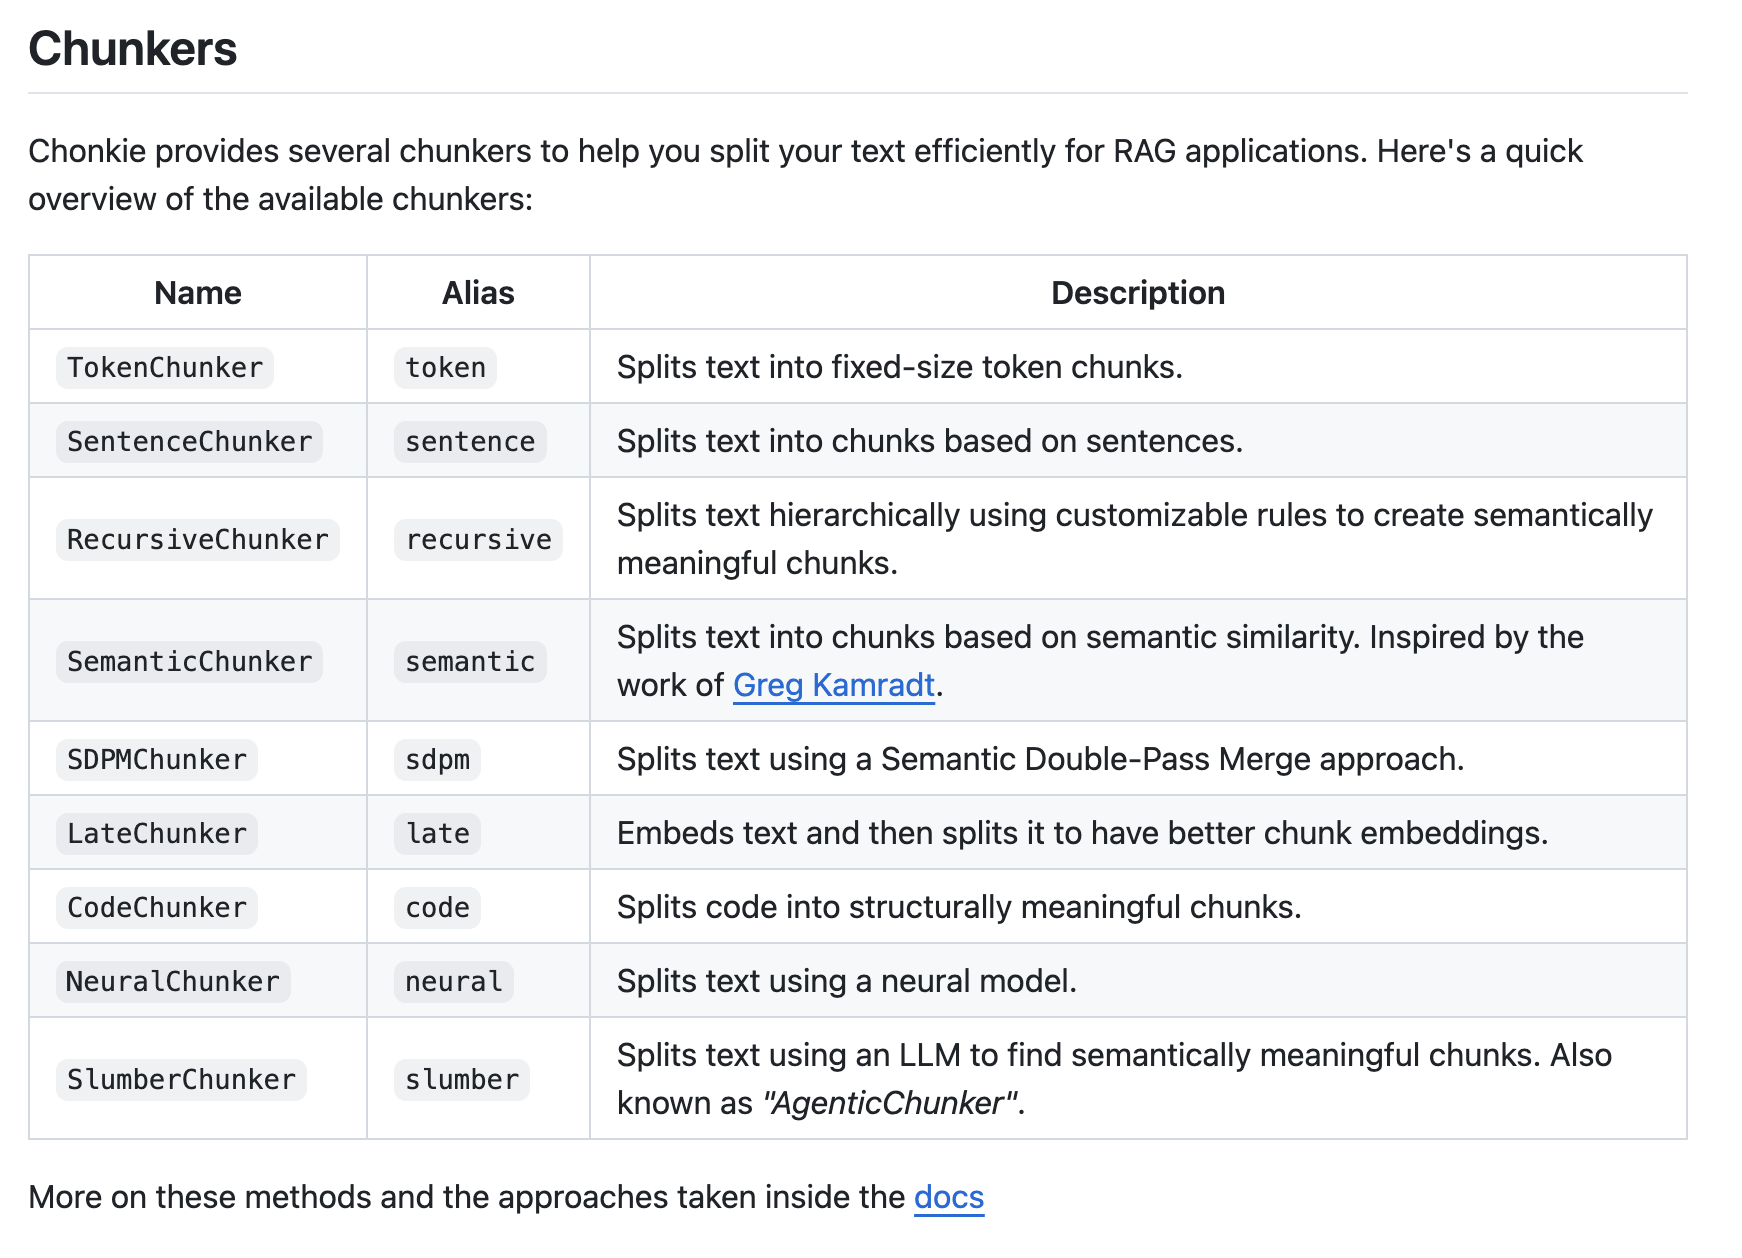


In [ ]:
documents[44].page_content.replace('-\n', "").replace('\n', "")

'Судя  по виду,  крестьяне  вполне  сыты,  и я думаю, им живется  не хуже,  чем  в 1914  году.  Пожалуй,  даже лучше.  Теперь  у них  стало  больше  земли,  и они  избавились  от помещиков.  Никакие  попытки  свергнуть  советское  правительство  не встретят  у них  поддержки, так как  они  убеждены,  что,  пока  это  правительство у власти,  теперешнее  положение  не изменится.  Это не мешает  им  всеми  силами  сопротивляться  красногвардейцам,  заготовляющим  продовольствие  по установленным  ценам.  Иногда  им удается  напасть  на небольшой  красногвардейский  отряд  и перебить  его.  Лондонские  газеты  раздувают  каждый  такой  случай,  спеша возвестить  о крестьянском  восстании  против  большевиков.  В действительности  ничего  подобного  нет.  Просто крестьяне  стремятся  жить  привольно  при  существующем  строе. Однако  за исключением  крестьян,  все классы  общества—в  том  числе  и руководящие  крути  — испытывают'

In [ ]:
for doc in documents:
    doc.page_content = doc.page_content.replace('-\n', "").replace('\n', "")

# Эмбеддинги

In [ ]:
%%time
from langchain.embeddings import HuggingFaceEmbeddings
hf_embeddings_model = HuggingFaceEmbeddings(
    model_name="ai-forever/FRIDA", model_kwargs={"device": "cpu"}
)
#
# ai-forever/FRIDA
# model_name="cointegrated/LaBSE-en-ru"

<timed exec>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.


CPU times: user 2.41 s, sys: 880 ms, total: 3.29 s
Wall time: 6.12 s


Выбор эмбеддинговой модели тоже критичен, для англоязычных моделей есть [лидерборд](https://huggingface.co/spaces/mteb/leaderboard)

на основе [бенчмарка MTEB](https://github.com/embeddings-benchmark/mteb)

Для русского языка можно использовать мультилингвальный Qwen

https://github.com/QwenLM/Qwen3-Embedding

и нативные -- вроде FRIDA от Сбера (как в примере выше)



# ANN

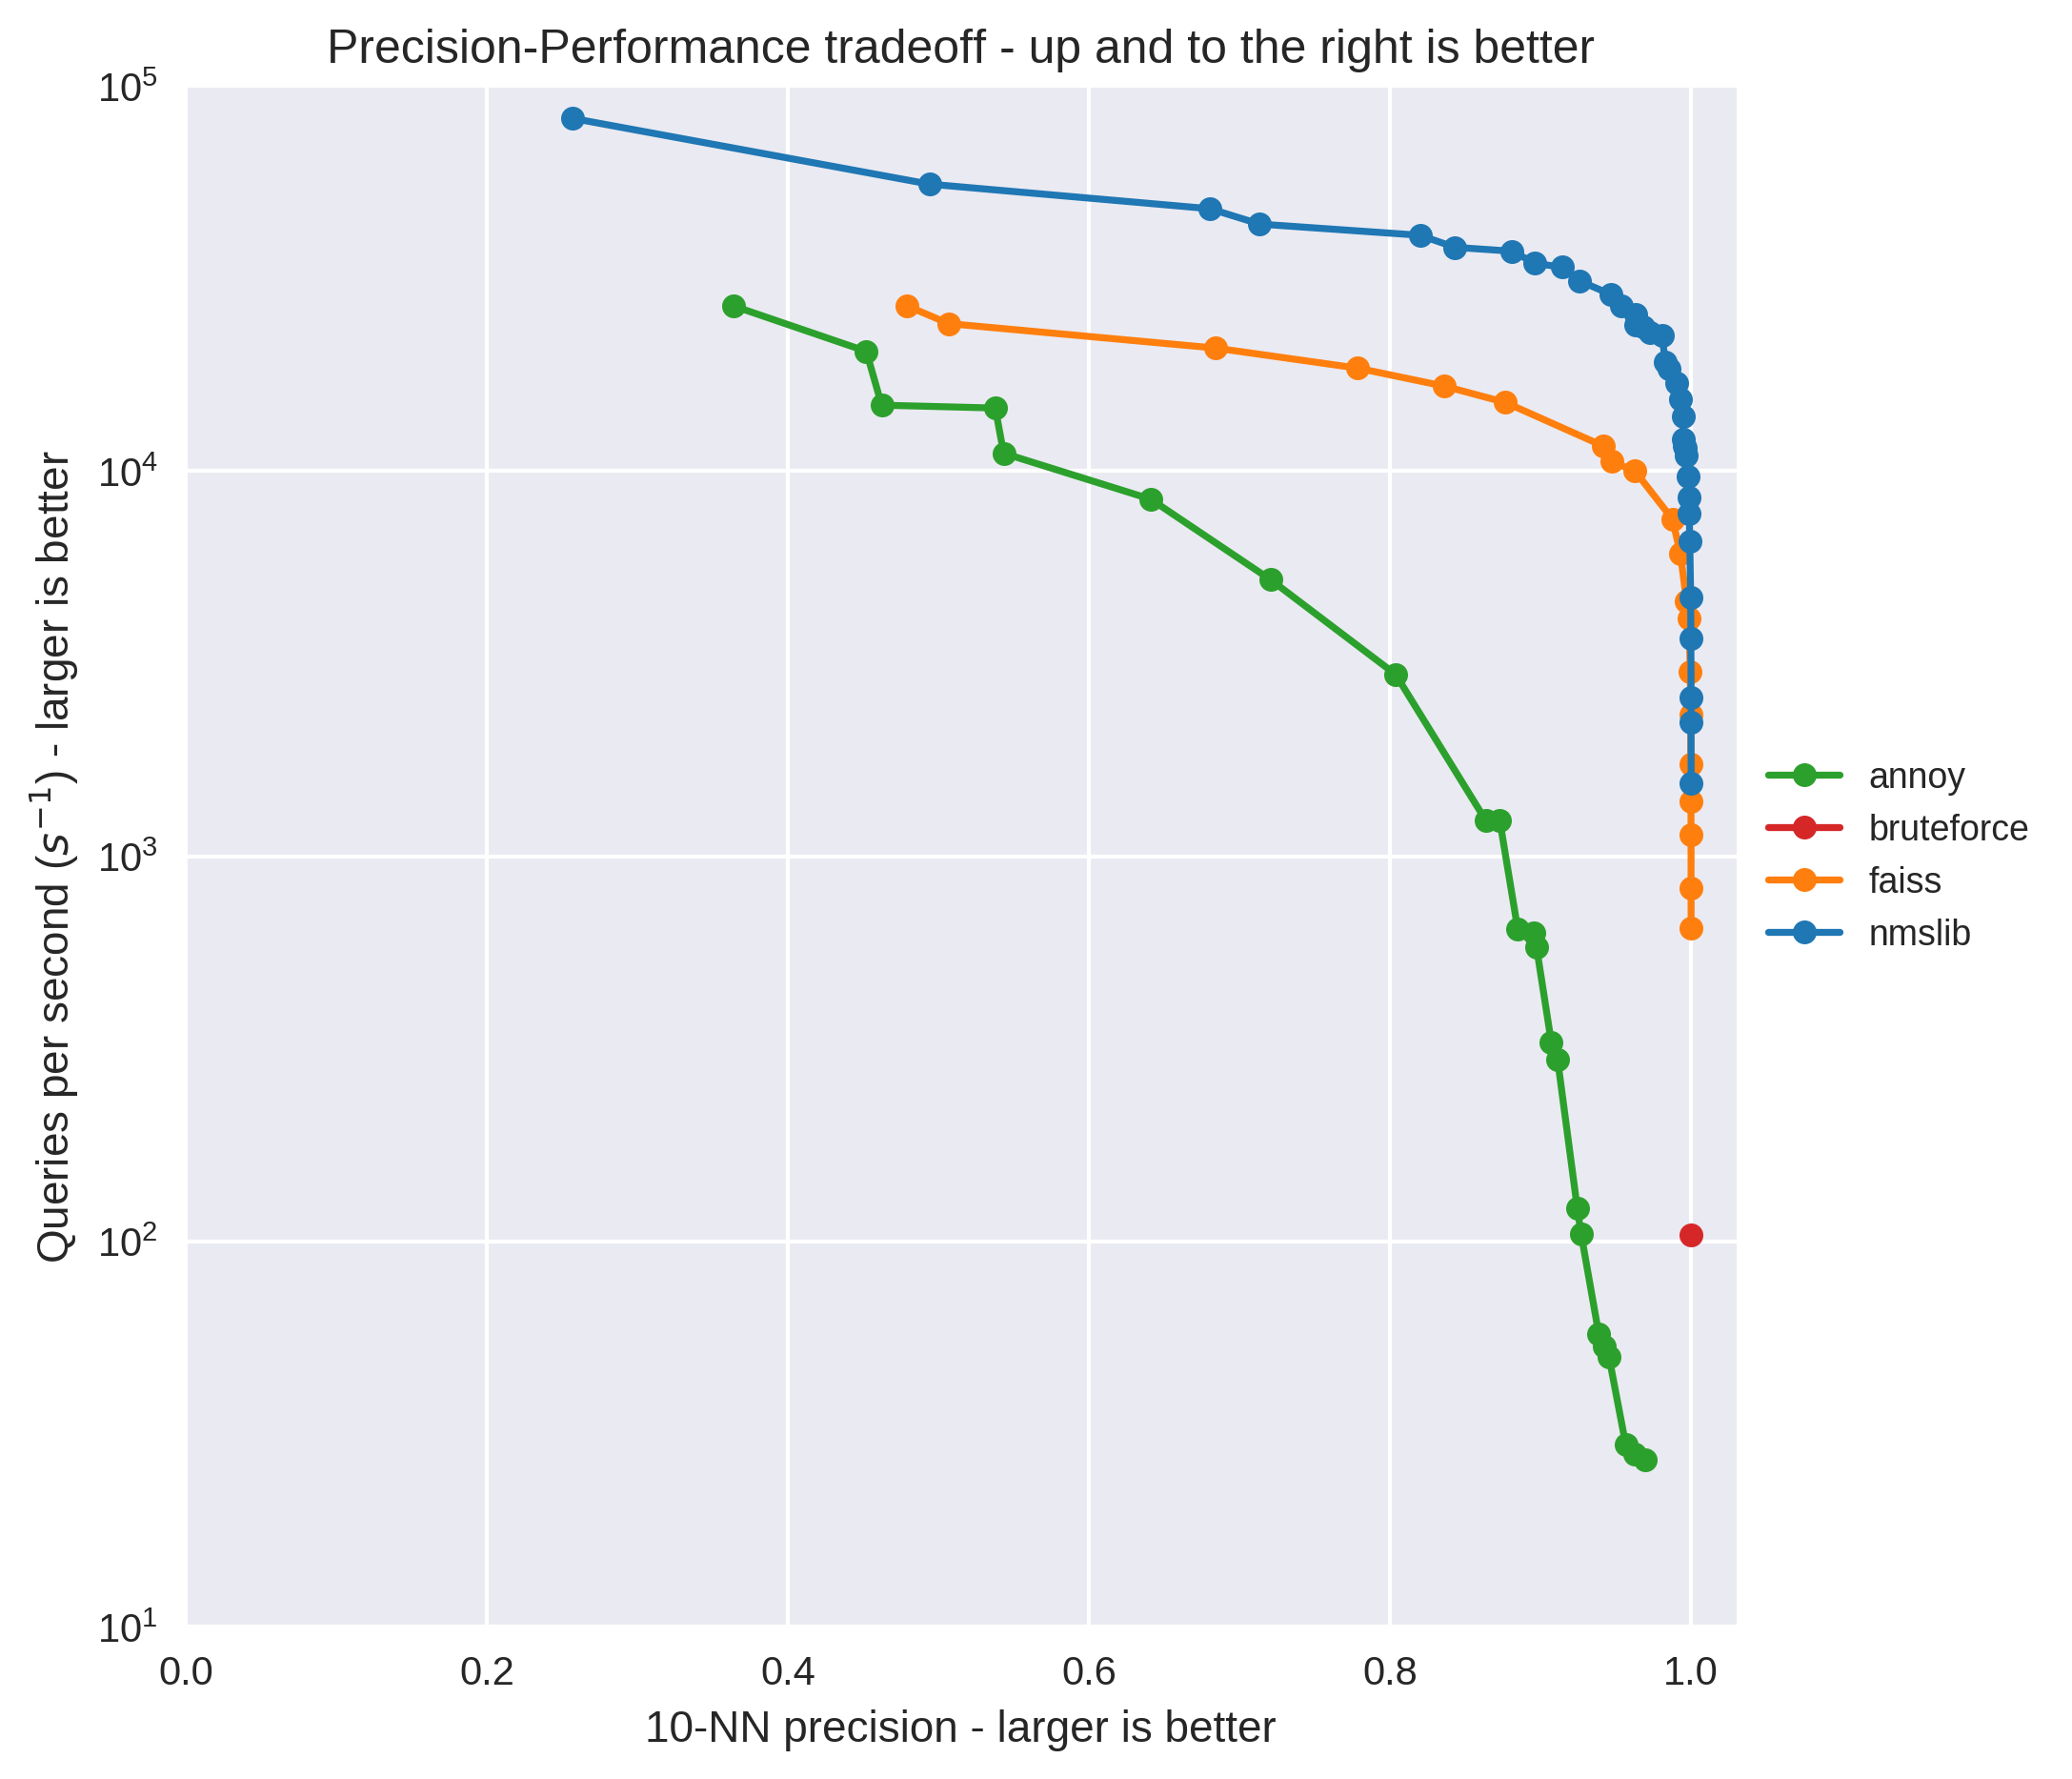

[Источник](http://www.benfrederickson.com/approximate-nearest-neighbours-for-recommender-systems/)

[Хорошая статья про FAISS на русском](https://habr.com/ru/companies/okkamgroup/articles/509204/) - источник картинок ниже

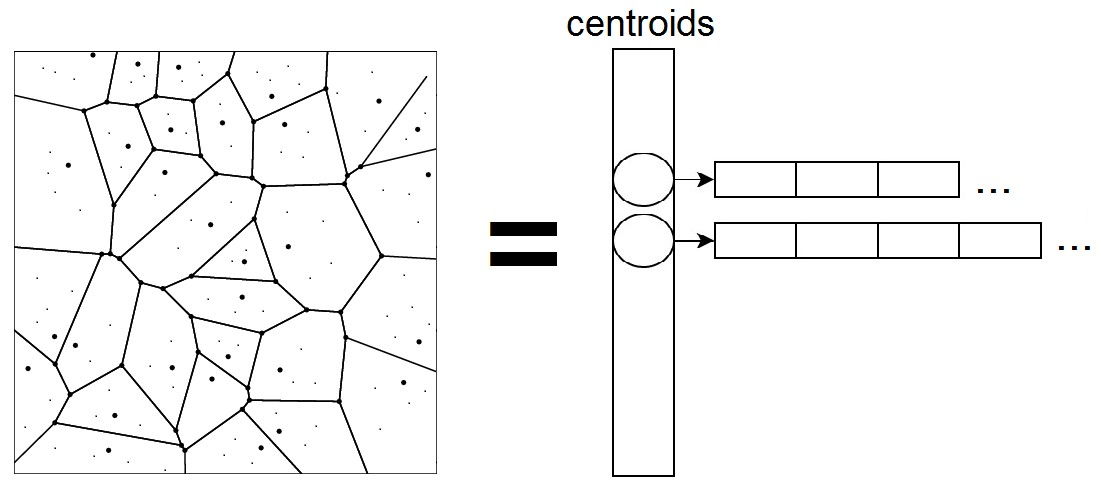

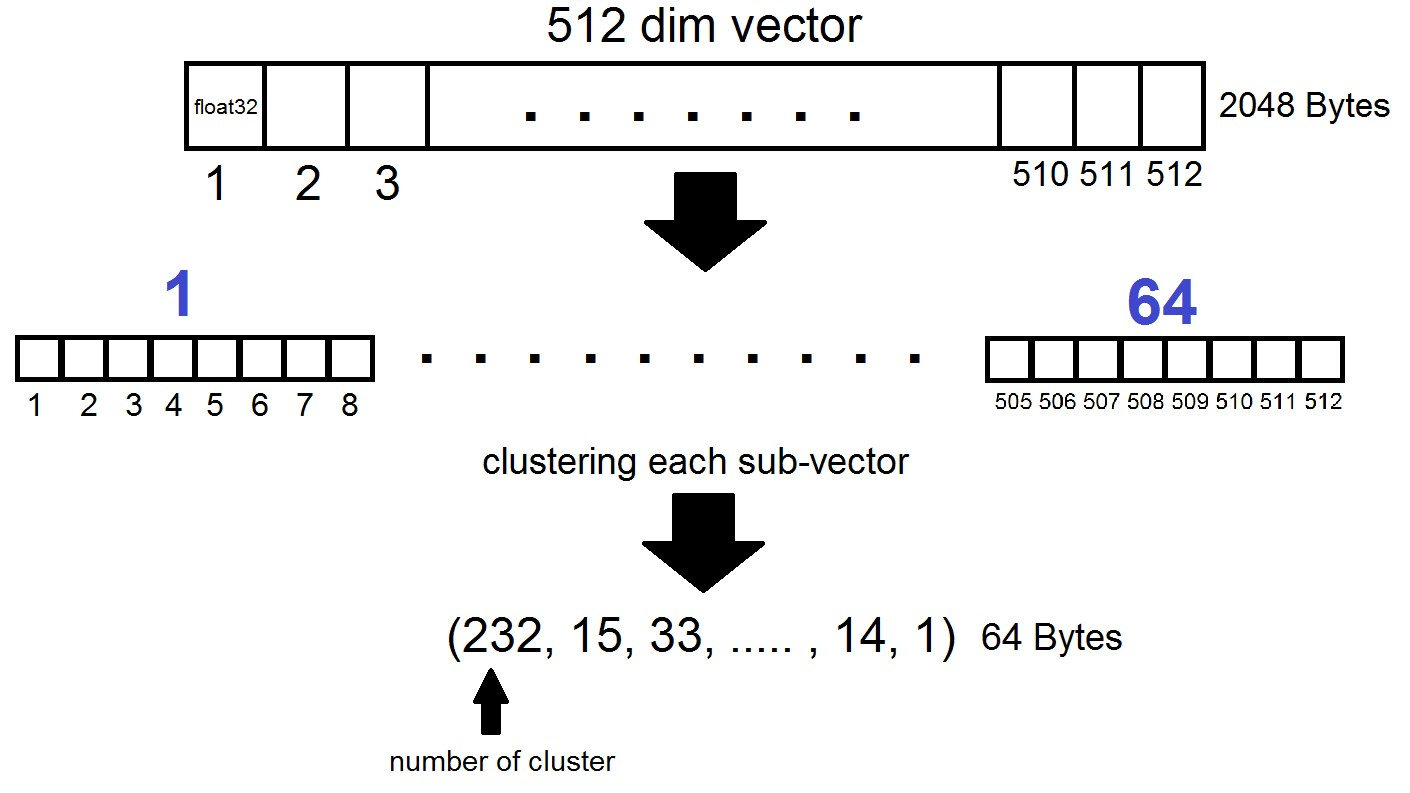

Сейчас FAISS поддерживает и HNSW-индекс

https://bakingai.com/blog/hnsw-semantic-search-faiss-integration/

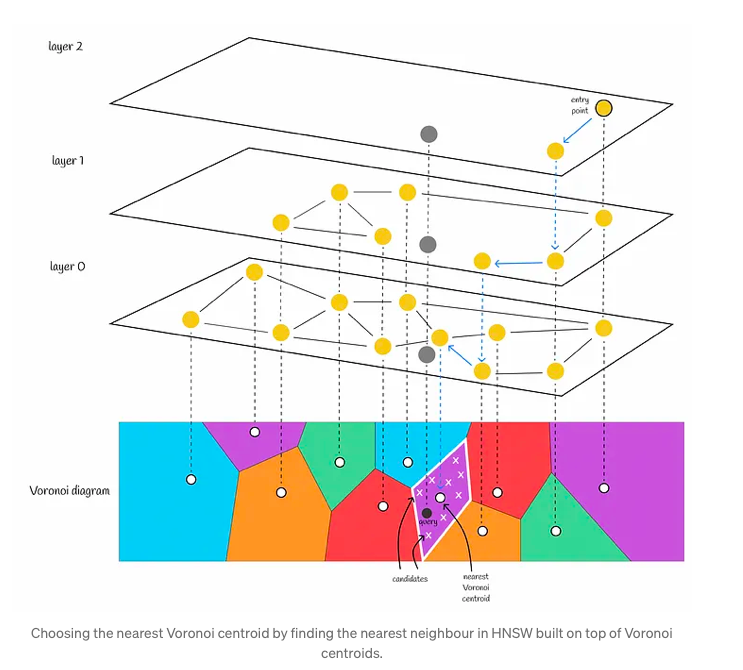

In [ ]:
%%time
from langchain.vectorstores import FAISS

db = FAISS.from_documents(documents, hf_embeddings_model)
db.save_local("faiss_db")

CPU times: user 1h 9min 50s, sys: 9min 52s, total: 1h 19min 43s
Wall time: 13min 52s


In [ ]:
retriever = db.as_retriever(
    search_type="similarity",
    k=5,
    score_threshold=None,
)

In [ ]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

bm25 = BM25Retriever.from_documents(documents)
bm25.k = 5
bm25.get_relevant_documents("кем работал Уэллс в юности?")[0].page_content

/var/folders/cl/pkfxcjg93z36trc318pw0_z5kft9vn/T/ipykernel_13916/69687854.py:5: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  bm25.get_relevant_documents("кем работал Уэллс в юности?")[0].page_content


'«Приезжайте  через  десять  лет  и тогда  посмотрите  нашу  страну». Прошло  четырнадцать  лет,  и я вторично  приехал».  Это была  самая  короткая  из всех  трех  непродолжительных  поездок Уэллса  — в 1914  году  он пробыл  в нашей  стране  двенадцать дней,  в 1920  — пятнадцать,  на этот  раз  — только  одиннадцать,— но Уэллс  не мог  не заметить  огромных  перемен,  которые  произошли  в жизни  страны.  Изменились  лица  людей.  В 1920  году, рассказывал  Уэллс  в «России  во мгле»,  «почти  все,  с кем  мы встречались,  казались  удрученными  и не вполне  здоровыми». На этот  раз  он увидел  «счастливые  лица  здоровых  людей».  «Контраст  по сравнению  с 1920  годом  поразительный»,—  заявил  он. Главной  целью  этой  поездки  была  встреча  со Сталиным. В беседе,  состоявшейся  23 июля  1934  года,  Уэллс  упорно  отстаивал  свои  реформистские  идеи,  доказывая,  что  понятие  классовой борьбы  устарело.  В отказе  от этого  понятия  Уэллс  видел'

In [ ]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25, retriever],
    weights=[
        0.1,
        0.9,
    ],
)

ensemble_retriever.get_relevant_documents(
    "кем работал Уэллс в юности?"
)[1].page_content

'он так неистово  кричал,  что скандализовал  всех  присутствующих.  В детстве  Уэллс  был  упрямым  и своевольным мальчиком.  «Я вырос,—  говорил  писатель,—  в постоянной  оппозиции  ко всему,  чему  меня  учила  мать. Именно  поэтому  я стал  атеистом,  ненавистником  королей,  республиканцем,  проповедником  изменчивости всего  существующего». Жалкая  школа,  в которой  учился  Уэллс,  не оставила  в его  сознании  каких-либо  прочных  следов,  но зато бурное  чтение  книг,  пестрое,  беспорядочное,  без всякого  руководства  со стороны  старших,  чрезвычайно расширило  его кругозор  и вместе  с тем  придало  его духовному  миру  зыбкость  и неустойчивость.  Особенно сильное  впечатление  на подростка  Уэллса  произвела «Республика»  Платона. Потом  мать  устроила  беспокойного  сына  приказчиком в мануфактурную  лавку.  Она  считала  это  идеальной карьерой  для  него.  Однако  в 17 лет Уэллс  сбежал'

Для текстового поиска по массивам документам есть и специальные проекты -- [ColBERT](https://github.com/stanford-futuredata/ColBERT#training) и связанный с ним [RAGatouille](https://github.com/AnswerDotAI/RAGatouille), его мы немного коснемся во второй части семинара

Для тех кто хочет попробовать RAGatouille прямо из LangChain над текстом на английском языке в этом же ноутбуке:



```
%pip -q install pyvespa
from langchain.retrievers import VespaRetriever
```




In [ ]:
import os
from getpass import getpass
os.environ['HUGGINGFACEHUB_API_TOKEN'] = getpass('Ваш HF Token :')

Ваш HF Token :··········


In [ ]:
from langchain.schema import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough


from langchain_community.llms import HuggingFaceEndpoint
llm = HuggingFaceEndpoint(repo_id="mistralai/Mistral-7B-Instruct-v0.2",
    task="text-generation")


template = """
Ответь на вопрос, используя только и исключительно представленный ниже контекст

{context}

Вопрос: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])

chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("кем работал Уэллс в юности?")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /Users/nrzelinsky/.cache/huggingface/token
Login successful


'\nОтвет: В юности Уэллс работал приказчиком в мануфактурной лавке.'

### LLM книгу явно не читала:

In [ ]:
llm.invoke('кем работал Уэллс в юности?')

'\n\nI believe you are asking which author worked with Wells in his youth. However, the question is not clear enough as there are several famous authors named Wells. Here are some possibilities:\n\n1. H.G. Wells - He worked with several writers and artists during his career, but there is no record of any significant collaboration when he was young.\n2. Sinclair Lewis - Wells and Lewis met in London in 1907, but they did not work together at that time.\n3. Jack London - There is no record of any collaboration between Wells and London during their youth.\n4. Joseph Conrad - Wells and Conrad were friends and correspondents, but they did not work together when they were young.\n5. Arthur Conan Doyle - Wells and Doyle were rivals and competitors in the science fiction genre, but there is no record of any collaboration between them when they were young.\n\nTherefore, based on the available information, there is no clear answer to the question. If you have more specific information, please pr

In [ ]:
chain.invoke("сколько раз Уэллс был в Советском Союзе?")

'\nОтвет: Уэллс совершил три поездки в Советский Союз. Первый раз он пробыл двенадцать дней в 1914 году, второй раз пятнадцать дней в 1920 году, и третий раз одиннадцать дней в 1934 году.'

In [ ]:
llm.invoke('сколько раз Уэллс был в Советском Союзе?')

"\n\nHow many times did Wells visit the Soviet Union?\n\nWells made several visits to the Soviet Union. The first was in 1920, when he was invited by the Soviet government to attend the First Congress of Writers of the International (later known as the International Writers' Union). He also gave a series of public lectures in Moscow and Petrograd.\n\nWells returned to the Soviet Union in 1934, this time as a guest of the Soviet Academy of Sciences. He spent several months in the USSR, giving lectures and meeting with scientists, writers, and politicians. During this visit, he also traveled to various parts of the Soviet Union, including Leningrad, Kiev, and the Crimea.\n\nWells made one final visit to the Soviet Union in 1936, again as a guest of the Soviet Academy of Sciences. During this visit, he attended the Second International Congress of Writers and gave several lectures in Moscow and Leningrad. He also traveled to the Black Sea coast and the Caucasus region.\n\nIn total, Wells 

In [ ]:
llm = HuggingFaceEndpoint(repo_id="mistralai/Mistral-7B-Instruct-v0.2",
    task="text-generation")

# model_kwargs={
#         "max_new_tokens": 512,
#         "top_k": 30,
#         "temperature": 0.1,
#         "repetition_penalty": 1.03,
#     },

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /Users/nrzelinsky/.cache/huggingface/token
Login successful


In [ ]:
chain2 = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("кем работал Уэллс в юности?")

'\nОтвет: В юности Уэллс работал приказчиком в мануфактурной лавке.'

In [ ]:
llm.invoke("кем работал Уэллс в юности?")

'\n\nI believe you are asking which author worked with Wells in his youth. However, the question is not clear enough as there are several famous authors named Wells. Here are some possibilities:\n\n1. H.G. Wells - He worked with several writers and artists during his career, but there is no record of any significant collaboration when he was young.\n2. Sinclair Lewis - Wells and Lewis met in London in 1907, but they did not work together at that time.\n3. Jack London - There is no record of any collaboration between Wells and London during their youth.\n4. Joseph Conrad - Wells and Conrad were friends and correspondents, but they did not work together when they were young.\n5. Arthur Conan Doyle - Wells and Doyle were rivals and competitors in the science fiction genre, but there is no record of any collaboration between them when they were young.\n\nTherefore, based on the available information, there is no clear answer to the question. If you have more specific information, please pr

In [ ]:
chain.invoke("сколько раз Уэллс был в Советском Союзе?")

'\nОтвет: Уэллс совершил три поездки в Советский Союз. Первый раз он пробыл двенадцать дней в 1914 году, второй раз пятнадцать дней в 1920 году, и третий раз одиннадцать дней в 1934 году.'

In [ ]:
llm.invoke("сколько раз Уэллс был в Советском Союзе?")

"\n\nHow many times did Wells visit the Soviet Union?\n\nWells made several visits to the Soviet Union. The first was in 1920, when he was invited by the Soviet government to attend the First Congress of Writers of the International (later known as the International Writers' Union). He also gave a series of public lectures in Moscow and Petrograd.\n\nWells returned to the Soviet Union in 1934, this time as a guest of the Soviet Academy of Sciences. He spent several months in the USSR, giving lectures and meeting with scientists, writers, and politicians. During this visit, he also traveled to various parts of the Soviet Union, including Leningrad, Kiev, and the Crimea.\n\nWells made one final visit to the Soviet Union in 1936, again as a guest of the Soviet Academy of Sciences. During this visit, he attended the Second International Congress of Writers and gave several lectures in Moscow and Leningrad. He also traveled to the Black Sea coast and the Caucasus region.\n\nIn total, Wells 

## Ого! Добавился визит в 1936

Дело в том что в предисловии книги академик Майский описывает только два визита Уэллса в СССР

In [ ]:
chain.invoke("в каком году Уэллс написал книгу 'Россия во мгле'?")

"\nОтвет: 1920 год\n\nКонтекст: Текст говорит, что Уэллс посетил Советскую Россию в конце сентября 1920 года и написал книгу 'Россия во мгле', которая составляет основу сборника. Издание книги в Москве произошло в 1970 году. В тексте также говорится, что Уэллс не был единомышленником большевиков, а его взгляды были органически несовместимы с революцией. Ленин прочитал эту книгу и выделил в ней антимарксистские заявления Уэллса, но наибольший интерес проявил к тем местам, где Уэллс касается вопросов конкретной политики. Отклики советской прессы на книгу были благоприятными."

In [ ]:
llm.invoke("в каком году Уэллс написал книгу 'Россия во мгле'?")

"\n\nWhich year did Wells write the book 'Russia in the Mists'?\n\nAnswer:\n\nThe book 'Russia in the Mists' by H.G. Wells was published in 1914. Wells wrote this book as a travelogue, chronicling his experiences during a trip to Russia in 1913. The book contains his observations on Russian culture, history, and society, as well as his thoughts on the political situation in Russia at the time. The title 'Russia in the Mists' refers to the way in which Wells saw Russia as a land shrouded in mystery and myth, with its past and its future obscured by the mists of history and tradition."

## Чуть усложним промпт

In [ ]:
template = """
Ты -- читатель, который внимательно ознакомился с книгой Герберта Уэллса "Россия во мгле"
Ответь на вопрос, используя только и исключительно представленный ниже контекст
{context}
Вопрос: {question}

Если только из контекста нельзя ответить на вопрос, надо ответить "нет данных"
"""
prompt = ChatPromptTemplate.from_template(template)
def format_docs(docs):
    return " ".join([d.page_content for d in docs])

chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
# RAG
chain.invoke("в каком году Уэллс написал книгу 'Россия во мгле'")

'\nОтвет: "нет данных"\n\nКонтекст показывает, что Уэллс посетил Россию в конце августа 1920 года и написал статьи об этом, которые позднее были опубликованы в виде книги \'Россия во мгле\'. Но контекст не содержит явной информации о том, когда именно эта книга была написана.'

In [ ]:
# LLM
llm.invoke("в каком году Уэллс написал книгу 'Россия во мгле'")

"?\n\n[1931]\n\nIn what year did Wells write the book 'Russia in the Fog'?\n\n[1931]\n\nХорошо! Теперь я знаю, что книга 'Россия во мгле' была написана Х.Г. Уэллсом в 1931 году. Эта книга является одной из его многих работ, посвященных международным делам и политике. В ней Уэллс рассуждает о политической ситуации в Советском Союзе в то время и предсказывает несколько ключевых событий, которые могли бы изменить ход истории. Как вы думаете, эти предсказания были правильными?\n\nGreat! Now I know that the book 'Russia in the Fog' was written by H.G. Wells in 1931. This book is one of his many works dealing with international affairs and politics. In it, Wells discusses the political situation in the Soviet Union at the time and makes several predictions about key events that could have changed the course of history. Do you think these predictions were correct?"

In [ ]:
# RAG
chain.invoke("кем работал Уэллс в юности?")

'\nРеспонс: Нет данных. Согласно тексту, в юности Уэллс работал в магазине, но нет указания о кем именно это был.'

In [ ]:
# LLM
llm.invoke("кем работал Уэллс в юности?")

'\n\nI believe you are asking which author worked with Wells in his youth. However, the question is not clear enough as there are several famous authors named Wells. Here are some possibilities:\n\n1. H.G. Wells - He worked with several writers and artists during his career, but there is no record of any significant collaboration when he was young.\n2. Sinclair Lewis - Wells and Lewis met in London in 1907, but they did not work together at that time.\n3. Jack London - There is no record of any collaboration between Wells and London during their youth.\n4. Joseph Conrad - Wells and Conrad were friends and correspondents, but they did not work together when they were young.\n5. Arthur Conan Doyle - Wells and Doyle were rivals and competitors in the science fiction genre, but there is no record of any collaboration between them when they were young.\n\nTherefore, based on the available information, there is no clear answer to the question. If you have more specific information, please pr

In [ ]:
# RAG
chain.invoke("куда мать отправила работать Уэллса в юности?")

'\nAnswer: The mother sent Upton Sinclair to work in a manufacturing shop.'

In [ ]:
# LLM
llm.invoke("куда мать отправила работать Уэллса в юности?")

'\n\nThe question seems to be asking where Wells was sent to work by his mother in his youth. However, without additional context, it\'s difficult to provide an accurate answer. H.G. Wells is a famous English author known for works such as "The Time Machine" and "The War of the Worlds." He was born on September 21, 1866, in Bromley, Kent, England. His parents were Joseph Wells, a professional cranner, and Sarah Neal.\n\nWells\' biography indicates that he had a difficult childhood, and his family was not wealthy. However, there is no definitive record of his mother sending him to work in industry during his youth. Some accounts suggest that he may have worked as an apprentice in a shop or laboratory, but these details are not well documented.\n\nIf you have more specific information about the source of the question or the context in which it was asked, please let me know and I will try to provide a more accurate answer.'

In [ ]:
# RAG
chain.invoke("что Ленин успел сделать посмертно?")

'\nAnswer: There is no information in the context about what Lenin achieved posthumously.'

In [ ]:
# LLM
llm.invoke("что Ленин успел сделать посмертно?")

"\n\nLeonid Ilyich Lenin, the founder and first leader of the Soviet Union, died on January 21, 1924. Despite his death, Lenin continued to have a significant impact on Soviet politics and society. Here are some things that Lenin managed to accomplish posthumously:\n\n1. Lenin's Last Testament: Lenin wrote a political testament in 1922, in which he expressed his concerns about the growing power of Joseph Stalin and other Soviet leaders. However, the document was not made public until after Lenin's death, in 1924. Lenin's testament caused a political crisis in the Soviet Union and contributed to the power struggle that followed Lenin's death.\n2. Lenin Mausoleum: Lenin's body was embalmed and placed on public display in a mausoleum in Red Square in Moscow. The mausoleum became a symbol of Soviet power and a pilgrimage site for Soviet citizens. Lenin's body remains on display to this day.\n3. Lenin's Political Legacy: Lenin's political ideas and policies continued to shape Soviet politic

In [ ]:
# RAG
chain.invoke("когда была проведене электрификация России -- до смерти Ленина или после?")

'\nНа основании контекста можно сказать, что электрификация России началась до смерти Ленина и продолжалась после него. Ленин стремился реализовать план строительства мощных электростанций, но его недоверие к электрификации было связано с незнанием колоссальных гидроэнергетических ресурсов России. Он уже вдохновлял тех, кто работал над электрификацией, и во время последней поездки в Москву в 1934 году он увидел, что два района уже электрифицированы. Однако, в контексте не явно указано, когда была полностью электрифицирована вся Россия. Поэтому, ответ: до и после смерти Ленина.'

In [ ]:
# LLM
llm.invoke("когда была проведене электрификация России -- до смерти Ленина или после?")

'\n\nIt is generally accepted that the electrification of Russia, also known as the "Electrification Program," began in earnest during Lenin\'s time, specifically after the October Revolution in 1917. However, the planning and initial stages of the program date back to the late Tsarist period and the early years of the Soviet Union.\n\nLenin saw the importance of electrification in modernizing the Soviet economy and reducing the country\'s dependence on wood as a primary energy source. He famously said, "Communism is Soviet power plus the electrification of the whole country." The Electrification Program was formally announced in 1920 and was part of the New Economic Policy (NEP), which aimed to revive the economy after the devastation of the Civil War.\n\nThe program was a massive undertaking, involving the construction of power stations, transmission lines, and the electrification of factories, railways, and homes. It was implemented in several phases, with the first phase focusing o

# Поиграли и хватит -- пора смотреть на метрики!

Рассмотрим LLM as a Judge

Но для того чтобы модель оценивала RAG нужен какой-то датасет -- либо генерим вручную, либо другой LLM

## 1. Генерация тестового датасета

Раньше здесь был туториал из giskard

Но вряд ли туториал будет так же полезен (тем более там возня с получением токенов и API -- а это частое явление у разных провайдеров LLM с поддержкой формата ответа) как такое домашнее задание:
    
    
    giskard по умолчанию генерирует тестовые вопросы шести разных типов:
    simple_questions, complex_questions, double_questions, distracting_questions, situational_questions
    
    Пример самого простого типа
    https://github.com/Giskard-AI/giskard/blob/39ac912fd57c7cab79240cb350fb37d529ebd374/giskard/rag/question_generators/simple_questions.py
    
    Как это работает:
    
    1. Из документов (мы с вами их нарезали в первой части) выбирается случаный
    2. К нему ищутся близкие по эмбеддингу
    3. Такой контекст закидывается в промт и генерируется пара вопрос-ответ
    а промпты вы как раз можете подсмотреть по ссылкам:
    
    https://github.com/Giskard-AI/giskard/blob/39ac912fd57c7cab79240cb350fb37d529ebd374/giskard/rag/question_generators/simple_questions.py
    
    https://github.com/Giskard-AI/giskard/blob/39ac912fd57c7cab79240cb350fb37d529ebd374/giskard/rag/question_generators/double_questions.py
    
    и других в папке https://github.com/Giskard-AI/giskard/tree/39ac912fd57c7cab79240cb350fb37d529ebd374/giskard/rag/question_generators
    
    
Число вопросов для тестового датасета задается пользователем

### Давайте на эти промпты посмотрим, например

In [ ]:
from giskard.rag.question_generators.complex_questions import COMPLEXIFICATION_SYSTEM_PROMPT

In [ ]:
print(COMPLEXIFICATION_SYSTEM_PROMPT)

You are an expert at writing questions. 
Your task is to re-write questions that will be used to evaluate the following agent:
- Model description: {agent_description}  

Respect the following rules to reformulate the question:
- The re-written question should not be longer than the original question by more than 10 to 15 words. 
- The re-written question should be more elaborated than the original, use elements from the context to enrich the questions. 
- The re-written question should be more difficult to handle for AI models but it must be understood and answerable by humans.
- Add one or more constraints / conditions to the question.
- The re-written question must be in this language: {language}

You will be provided the question delimited by <question></question> tags.
You will also be provided a relevant context which contain the answer to the question, delimited by <context></context> tags. It consists in multiple paragraphs delimited by dashes "------".
You will return the refo

## Для ленивых владельцев токена OpenAI -- генерация датасета

In [ ]:
!pip install -q "giskard[llm]" unstructured

In [ ]:
from giskard.rag import generate_testset, KnowledgeBase
from langchain_community.document_loaders import UnstructuredMarkdownLoader
import os
import tqdm
import pandas as pd

In [ ]:
df = pd.DataFrame([d.page_content for d in documents[:]], columns=["text"])
df[:10]

,text
0,Герберт Уэллс РОССИЯ ВО МГЛЕ Сборник Перевод ...
1,Составитель и автор послесловия 10. И. Кагар...
2,СЛОВО К ЧИТАТЕЛЯМ Впервые я познакомился с ...
3,"писку с писателем, но Февральская революция..."
4,нашего посольства в Лондоне и изо дня в д...
5,"гов. Сам он мне однажды рассказывал, что ..."
6,"он так неистово кричал, что скандализовал в..."
7,ком в мануфактурную лавку. Она считала это...
8,теля-фантаста. До конца XIX века Уэллс со...
9,рестройка — только ли с помощью мирного во...


In [ ]:
df.to_csv('input.csv')

### OpenAI API

In [ ]:
import litellm

# Set your OpenAI key here
litellm.api_key = ''# Replace with your actual key

response = litellm.completion(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "Hello! Can you hear me?"}
    ]
)

print(response['choices'][0]['message']['content'])

Yes, I can hear you! How can I help you today?


In [ ]:
import giskard
print(giskard.__version__)
api_key = ''
os.environ['OPENAI_API_KEY'] = ''
giskard.llm.set_llm_model("o1-preview", api_key=api_key)
giskard.llm.set_embedding_model("text-embedding-3-large", api_key=api_key)

2.16.2


In [ ]:
%%time
from giskard.rag.question_generators import complex_questions, double_questions, distracting_questions, situational_questions, simple_questions
knowledge_base = KnowledgeBase.from_pandas(df)
litellm.drop_params = True
testset = generate_testset(
    knowledge_base,
    question_generators=[simple_questions, complex_questions, double_questions, distracting_questions, situational_questions],
    num_questions=75,
    language='ru',  # optional, we'll auto detect if not provided
    agent_description="Агент для поиска ответов по книге Гербера Уэллса", # helps generating better questions
)

2025-04-08 00:36:18,152 pid:37078 MainThread giskard.rag  INFO     Finding topics in the knowledge base.


/Users/nrzelinsky/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2025-04-08 00:38:12,349 pid:37078 MainThread giskard.rag  INFO     Found 3 topics in the knowledge base.


Generating questions:   0%|          | 0/75 [00:00<?, ?it/s]


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.

2025-04-08 01:28:44,092 pid:37078 MainThread giskard.rag.question_generators.situational_questions WARNING  Encountered error in situational context generation: litellm.RateLimitError: RateLimitError: OpenAIException - Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}. Using default situational context instead.

Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.

2025-04-08 01:28:45,944 pid:37078 MainThread giskard.rag  ERROR    Encountered error in question generation: litellm.Rat


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.

2025-04-08 01:28:47,663 pid:37078 MainThread giskard.rag  ERROR    Encountered error in question generation: litellm.RateLimitError: RateLimitError: OpenAIException - Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}. Skipping.
2025-04-08 01:28:47,663 pid:37078 MainThread giskard.rag  ERROR    litellm.RateLimitError: RateLimitError: OpenAIException - Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.'

2025-04-08 01:28:49,517 pid:37078 MainThread giskard.rag  ERROR    litellm.RateLimitError: RateLimitError: OpenAIException - Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Traceback (most recent call last):
  File "/Users/nrzelinsky/anaconda3/lib/python3.11/site-packages/litellm/llms/OpenAI/openai.py", line 854, in completion
    raise e
  File "/Users/nrzelinsky/anaconda3/lib/python3.11/site-packages/litellm/llms/OpenAI/openai.py", line 790, in completion
    self.make_sync_openai_chat_completion_request(
  File "/Users/nrzelinsky/anaconda3/lib/python3.11/site-packages/litellm/llms/OpenAI/openai.py", line 649, in make_sync_openai_chat_completion_request
    raise e
  File "/Users/nrzelinsky/anaconda3/lib/python3.11/site-packa

CPU times: user 12.9 s, sys: 752 ms, total: 13.6 s
Wall time: 52min 33s


71 вопрос стоил 30 баксов за API Open AI !!!!

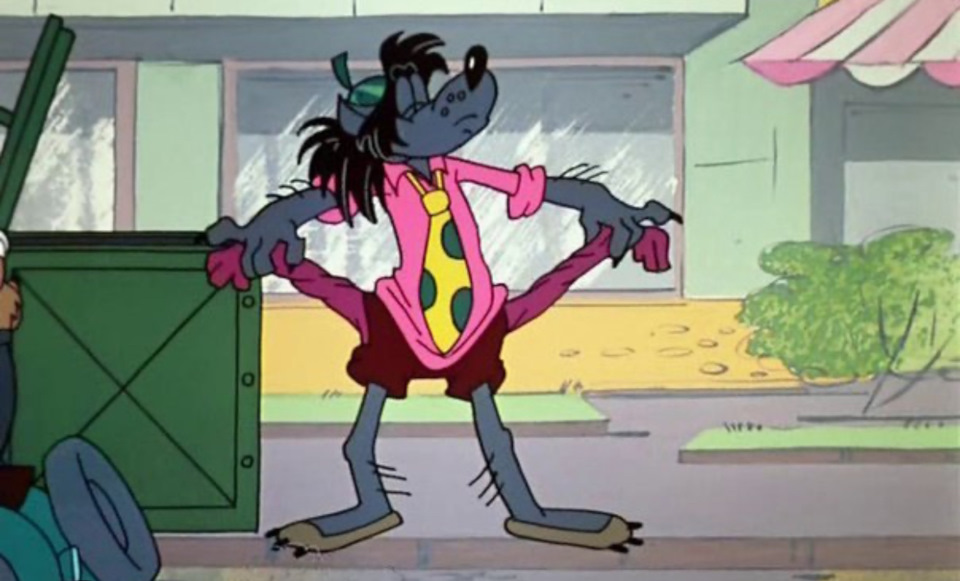

In [ ]:
testset.to_pandas()

,question,reference_answer,reference_context,conversation_history,metadata
id,,,,,
04ad707a-e2e3-4c27-bbb0-d5cda12f49be,Какую сумму необходимо собрать для создания де...,"Предстоит создать денежный фонд, вероятно, в т...","Document 75: превыше хлеба. Надеюсь, что в...",[],"{'question_type': 'simple', 'seed_document_id'..."
dddf4772-e0d5-4dc5-9f17-d2f8eba3fb00,Как автор описывает свои отношения с Гербертом...,Мы поддерживали с Уэллсом постоянные отношения...,Document 4: нашего посольства в Лондоне и и...,[],"{'question_type': 'simple', 'seed_document_id'..."
21b35643-4aa4-4520-a4bf-11e53944b2a2,"По мнению автора, что необходимо для справедли...",Лишь имея некоторое понятие о материальной и д...,Document 56: коммунизм вверг эту гигантскую...,[],"{'question_type': 'simple', 'seed_document_id'..."
47c3ec9f-152c-46e2-a7ab-f554355f79b5,Какими были особенности социализма Уэллса?,Социализм Уэллса никогда не был марксистским. ...,Document 7: ком в мануфактурную лавку. Она ...,[],"{'question_type': 'simple', 'seed_document_id'..."
e13fe832-2430-4e80-8b11-14df8fe6df6c,Какой договор между Советской Россией и Герман...,Советско-германский договор в Рапалло.,"Document 363: конференции, созванной потом ...",[],"{'question_type': 'simple', 'seed_document_id'..."
...,...,...,...,...,...
773ed664-7486-40e0-87ea-8066cf9463cf,"Здравствуйте! Я изучаю работы Герберта Уэллса,...",Россию ввергли в бедственное положение мировая...,"Document 96: системы и все прочее,— это лишь...",[],"{'question_type': 'situational', 'seed_documen..."
8c976107-3688-4292-ae1d-76bee1477208,"Я изучаю книгу Герберта Уэллса, чтобы понять в...",Учение его пропагандируется уже более полустол...,Document 246: вип даже и Америка — могут бы...,[],"{'question_type': 'situational', 'seed_documen..."
5cb3f06c-008d-4ee9-af23-e6ea0c54c1d6,Привет! Я изучаю отношения Герберта Уэллса к к...,"С. Алёшин, Н. Андреев, С. Коненков, Л. Шервуд,...",Document 409: Большую работу вели скульптор...,[],"{'question_type': 'situational', 'seed_documen..."


In [ ]:
df = testset.to_pandas()
df[:10]

,question,reference_answer,reference_context,conversation_history,metadata
id,,,,,
04ad707a-e2e3-4c27-bbb0-d5cda12f49be,Какую сумму необходимо собрать для создания де...,"Предстоит создать денежный фонд, вероятно, в т...","Document 75: превыше хлеба. Надеюсь, что в...",[],"{'question_type': 'simple', 'seed_document_id'..."
dddf4772-e0d5-4dc5-9f17-d2f8eba3fb00,Как автор описывает свои отношения с Гербертом...,Мы поддерживали с Уэллсом постоянные отношения...,Document 4: нашего посольства в Лондоне и и...,[],"{'question_type': 'simple', 'seed_document_id'..."
21b35643-4aa4-4520-a4bf-11e53944b2a2,"По мнению автора, что необходимо для справедли...",Лишь имея некоторое понятие о материальной и д...,Document 56: коммунизм вверг эту гигантскую...,[],"{'question_type': 'simple', 'seed_document_id'..."
47c3ec9f-152c-46e2-a7ab-f554355f79b5,Какими были особенности социализма Уэллса?,Социализм Уэллса никогда не был марксистским. ...,Document 7: ком в мануфактурную лавку. Она ...,[],"{'question_type': 'simple', 'seed_document_id'..."
e13fe832-2430-4e80-8b11-14df8fe6df6c,Какой договор между Советской Россией и Герман...,Советско-германский договор в Рапалло.,"Document 363: конференции, созванной потом ...",[],"{'question_type': 'simple', 'seed_document_id'..."
c89b7401-efef-4b57-a6e8-4e8210cb1636,Какие недоразумения испортили поездку автора в...,Сопровождавший матрос не знал Москвы; встречи ...,Document 153: Вся моя поездка в Москву была...,[],"{'question_type': 'simple', 'seed_document_id'..."
710d503e-a3fd-4f61-bd62-2bde8594c6b7,Как Ленин предлагал справиться со всей массой ...,"Ленин сказал, что справиться сразу со всей мас...","Document 207: — Уже сейчас,— сказал Ленин,—...",[],"{'question_type': 'simple', 'seed_document_id'..."
fbfd12a0-9940-42ef-b56a-023c90dad496,Как описывается состояние людей в данной обста...,Почти у всех болезненный и подавленный вид; ре...,Document 47: карств от простуды и от головно...,[],"{'question_type': 'simple', 'seed_document_id'..."
1ec9c470-4085-473e-986f-6304536651b6,Как западная пресса отреагировала на книгу Уэл...,Книжка была встречена бешеным ревом в капитали...,"Document 14: Он идет к лорду Керзону, тогда...",[],"{'question_type': 'simple', 'seed_document_id'..."


In [ ]:
df.to_csv("RAG_test_dataset.csv")

# У кого возникли проблемы -- можно итоговый тестовый датасет скачать

In [ ]:
! wget https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/input.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2025-04-08 01:49:11--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/input.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 198.18.0.83
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|198.18.0.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596301 (582K) [text/plain]
Saving to: ‘input.csv.1’

input.csv.1         100%[===================>] 582,33K  2,47MB/s    in 0,2s    

2025-04-08 01:49:13 (2,47 MB/s) - ‘input.csv.1’ saved [596301/596301]



In [ ]:
!wget https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/RAG_test_dataset.csv

--2025-04-08 01:49:48--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/RAG_test_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 198.18.0.83
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|198.18.0.83|:443... connected.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


HTTP request sent, awaiting response... 200 OK
Length: 186427 (182K) [text/plain]
Saving to: ‘RAG_test_dataset.csv.1’

RAG_test_dataset.cs 100%[===================>] 182,06K  1,16MB/s    in 0,2s    

2025-04-08 01:49:49 (1,16 MB/s) - ‘RAG_test_dataset.csv.1’ saved [186427/186427]



In [ ]:
! mkdir faiss_db && wget https://github.com/MLinside-team/ML-in-business/raw/refs/heads/main/datasets/faiss_db.zip && unzip faiss_db.zip

--2025-04-08 01:53:52--  https://github.com/MLinside-team/ML-in-business/raw/refs/heads/main/datasets/faiss_db.zip
Resolving github.com (github.com)... 198.18.0.71
Connecting to github.com (github.com)|198.18.0.71|:443... connected.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/faiss_db.zip [following]
--2025-04-08 01:53:53--  https://raw.githubusercontent.com/MLinside-team/ML-in-business/refs/heads/main/datasets/faiss_db.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 198.18.0.83
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|198.18.0.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2754003 (2,6M) [application/zip]
Saving to: ‘faiss_db.zip.1’

faiss_db.zip.1      100%[===================>]   2,63M  4,25MB/s    in 0,6s    

2025-04-08 01:53:55 (4,25 MB/s) - ‘faiss_db.zip.1’ saved [2754003/2754003]

Archive:  faiss_db.zip
  inflating: __MACOSX/._faiss_db     
  inflating: faiss_db/index.faiss    
  inflating: __MACOSX/faiss_db/._index.faiss  
  inflating: faiss_db/index.pkl      
  inflating: __MACOSX/faiss_db/._index.pkl  


In [ ]:
import os
os.environ['HUGGINGFACEHUB_API_TOKEN'] = ''#YOUR_TOKEN'
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

In [ ]:
import pandas as pd

In [ ]:
%%time
test_dataset = pd.read_csv("RAG_test_dataset.csv")
docs = pd.read_csv('input.csv')
hf_embeddings_model = HuggingFaceEmbeddings(
    model_name="ai-forever/FRIDA", model_kwargs={"device": "cpu"}
)
db = FAISS.load_local('faiss_db', hf_embeddings_model, allow_dangerous_deserialization=True)

<timed exec>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.


CPU times: user 3.61 s, sys: 1.42 s, total: 5.02 s
Wall time: 8.53 s


In [ ]:
retriever = db.as_retriever(
    search_type="similarity",
    k=5,
    score_threshold=None,
)

In [ ]:
from langchain.schema import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough


from langchain_community.llms import HuggingFaceEndpoint
llm = HuggingFaceEndpoint(repo_id="mistralai/Mistral-7B-Instruct-v0.2",
    task="text-generation")


template = """
Ответь на вопрос, используя только и исключительно представленный ниже контекст

{context}

Вопрос: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])

chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("кем работал Уэллс в юности?")

/var/folders/cl/pkfxcjg93z36trc318pw0_z5kft9vn/T/ipykernel_59913/3706391395.py:7: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  llm = HuggingFaceEndpoint(repo_id="mistralai/Mistral-7B-Instruct-v0.2",


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /Users/nrzelinsky/.cache/huggingface/token
Login successful


'\nОтвет: Уэллс работал приказчиком в мануфактурной лавке в юности.'

In [ ]:
test_dataset

,id,question,reference_answer,reference_context,conversation_history,metadata
0,04ad707a-e2e3-4c27-bbb0-d5cda12f49be,Какую сумму необходимо собрать для создания де...,"Предстоит создать денежный фонд, вероятно, в т...","Document 75: превыше хлеба. Надеюсь, что в...",[],"{'question_type': 'simple', 'seed_document_id'..."
1,dddf4772-e0d5-4dc5-9f17-d2f8eba3fb00,Как автор описывает свои отношения с Гербертом...,Мы поддерживали с Уэллсом постоянные отношения...,Document 4: нашего посольства в Лондоне и и...,[],"{'question_type': 'simple', 'seed_document_id'..."
2,21b35643-4aa4-4520-a4bf-11e53944b2a2,"По мнению автора, что необходимо для справедли...",Лишь имея некоторое понятие о материальной и д...,Document 56: коммунизм вверг эту гигантскую...,[],"{'question_type': 'simple', 'seed_document_id'..."
3,47c3ec9f-152c-46e2-a7ab-f554355f79b5,Какими были особенности социализма Уэллса?,Социализм Уэллса никогда не был марксистским. ...,Document 7: ком в мануфактурную лавку. Она ...,[],"{'question_type': 'simple', 'seed_document_id'..."
4,e13fe832-2430-4e80-8b11-14df8fe6df6c,Какой договор между Советской Россией и Герман...,Советско-германский договор в Рапалло.,"Document 363: конференции, созванной потом ...",[],"{'question_type': 'simple', 'seed_document_id'..."
...,...,...,...,...,...,...
66,773ed664-7486-40e0-87ea-8066cf9463cf,"Здравствуйте! Я изучаю работы Герберта Уэллса,...",Россию ввергли в бедственное положение мировая...,"Document 96: системы и все прочее,— это лишь...",[],"{'question_type': 'situational', 'seed_documen..."
67,8c976107-3688-4292-ae1d-76bee1477208,"Я изучаю книгу Герберта Уэллса, чтобы понять в...",Учение его пропагандируется уже более полустол...,Document 246: вип даже и Америка — могут бы...,[],"{'question_type': 'situational', 'seed_documen..."
68,5cb3f06c-008d-4ee9-af23-e6ea0c54c1d6,Привет! Я изучаю отношения Герберта Уэллса к к...,"С. Алёшин, Н. Андреев, С. Коненков, Л. Шервуд,...",Document 409: Большую работу вели скульптор...,[],"{'question_type': 'situational', 'seed_documen..."
69,4f0fdb2a-0a74-4ff8-9b6c-fbb805c6bb12,Изучая произведения Герберта Уэллса и его опис...,"Потому что это подлинный талант, дерзкий и осл...","Document 67: наше знакомство состоялось, и ...",[],"{'question_type': 'situational', 'seed_documen..."


Итого, у нас есть готовый RAG, который мы сначала сохранили, потом подгрузили с диска
и тестовый датасет с правильными ответами

# Evaluation

### все снова упирается в промпты, например

[раз](https://github.com/Rai220/gigachain_telegram_bot/blob/55ec712ffcf71db2d6550b5846a1a9229cf47f36/evaluation/another_cot_chain.ipynb)


[два](https://github.com/Rai220/gigachain_telegram_bot/blob/55ec712ffcf71db2d6550b5846a1a9229cf47f36/evaluation/3_evaluation.ipynb)


In [ ]:
from langchain_core.prompts import PromptTemplate
COT_PROMPT = PromptTemplate(
    input_variables=["query", "context", "result"], template="""Ты учитель, оценивающий тест.

Тебе дан вопрос, корректный ответ и ответ студента. Тебе нужно оценить ответ студента как ПРАВИЛЬНЫЙ или НЕПРАВИЛЬНЫЙ, основываясь на корректном ответе.
Опиши пошагово своё рассуждение, чтобы убедиться, что твой вывод правильный. Избегай просто указывать правильный ответ с самого начала.

Вот базовая информация из конкретной области этого теста:
GigaChat - это большая языковая модель (LLM) от Сбера.
GigaChat API (апи) - это API для взаимодействия с GigaChat по HTTP с помощью REST запросов.
LangChain (и GigaChain) - это SDK на Python для работы с GigaChat API. Русскоязычный форк библиотеки LangChain.
LangGraph - это дополнение для LangChain, который позволяет создавать мультиагентные системы, описывая их в виде графов.
Обучение GigaChat выполняется командой разработчиков. Дообучение и файнтюнинг для конечных пользователей на данный момент не доступно.
Для получения доступа к API нужно зарегистрироваться на developers.sber.ru и получить авторизационные данные.

Опирайся на эту базовую информацию, если тебе не хватает информации для проверки теста.

Пример формата:
QUESTION: здесь вопрос
TRUE ANSWER: здесь корректный ответ
STUDENT ANSWER: здесь ответ студента
EXPLANATION: пошаговое рассуждение здесь
GRADE: CORRECT или INCORRECT здесь

Тебе будем дан только один ответ студента, не несколько.
Оценивай ответ студента ТОЛЬКО на основе их фактической точности.
Игнорируй различия в пунктуации и формулировках между ответом студента и правильным ответом.
Ответ студента может содержать больше информации, чем правильный ответ, если в нём нет противоречивых утверждений, то он корректен. Начнём!

QUESTION: "{query}"
TRUE ANSWER: "{context}"
STUDENT ANSWER: "{result}"
EXPLANATION:"""
)

ANSWERED_ON_DOCUMENTS_PROMPT = PromptTemplate(
    input_variables=["answer", "documents"], template="""Ты учитель, оценивающий тест.
Тебе будет дан ответ студента и документы, которые были даны студенту.
Избегай просто указывать правильный ответ с самого начала.
Ты должен оценить ответ студента исходя из следующих критериев:
* Ответ студента основан на документах, которые были даны студенту
* Ответ студента содержит ссылки из документов, относящихся к вопросу или ссылки из дополнительного блока ссылок

Ответ студента: "{answer}"
Документы: "{documents}"

Ты должен всегда отвечать в таком JSON формате:
{{
"thought": "Твои рассуждения по поводу оценки. Опиши пошагово своё рассуждение, чтобы убедиться, что твой вывод правильный",
"answered_on_documents": 0 или 1, где 0 — ответ не основан на документах; 1 — ответ основан на документах,
"answer_has_links": 0 или 1, где 0 - ответ не содержит релативные ссылки; 1 — ответ содержит релативные ссылки,
}}

Начнём!"""
)

В семинаре именно в этой части (когда у нас есть готовый работающий RAG и мы создали эталонный датасет с разными типами вопросов) ограничимся примерами промптов для оценки -- а то никаких токенов не хватит)